# Lab 4
## Setup & Constants
Even if you may not need them each time, constants like kt, etc should generally be included

**Note:** the usual value for b assumes a freely rotating shaft and collar.  We obviously don't have that this time so we will find it experimentally in the last section.

In [22]:
import matplotlib.pyplot as plt
from control.matlab import tf, step
from math import pi, sqrt
import numpy as np
from scipy.io import loadmat
import pandas as pd

In [23]:
# motor torque constant (N-m/A)
kt = 0.05

# degrees to radians
kdr = 2*pi/360

# vector of current commands to try in motorlab
i = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2] 
# vector of position data - determined from motorlab
angle = [-29.7, -20.7, -14.85, -6.97, 0, 6.75, 14.85, 23.4, 30.15]

# convert deg to rad
theta = [kdr * x for x in angle]

# convert current vector to torque vector
T = [kt * x for x in i]

## Torque vs Angular Position Experimental and Estimated Plot
* Collect a squarewave response from the motorlab as described in the handout
* Be sure to name the variable "stepdata" so that the code matches your data
* Remember to set the *Sample Rate* to 500 Hz, then press the *Calculate Step Response Timing* before collecting stepdata

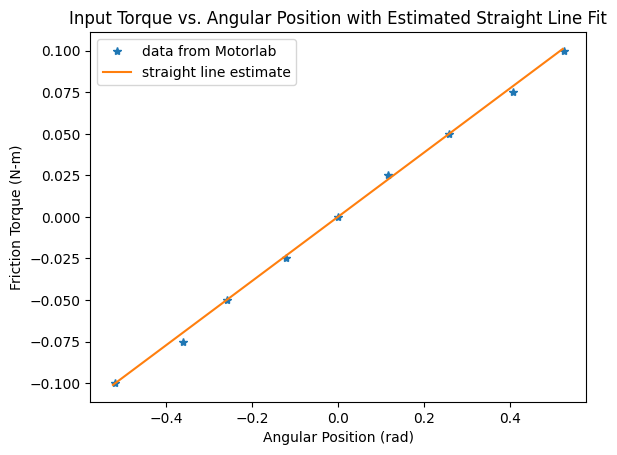

In [24]:
# generate two points for straight line fit
# the spring isn't likely to move more than 30 degrees

# angle estimate
theta_estimate = [(pi/180) * x for x in [-30, 30]]

# What is the slope of our motorlab theta vs torque?
# first order polynomial fit (returns slope and intercept)
fit = np.polyfit(theta, T, 1)

# slope is first element
k_estimate = fit[0]

# Torque estimate using slope found above
T_estimate = [k_estimate * x for x in theta_estimate]
 
# plot straight line with data
plt.figure(1)
plt.plot(theta, T, '*', theta_estimate, T_estimate)
plt.ylabel('Friction Torque (N-m)')
plt.xlabel('Angular Position (rad)')
plt.title('Input Torque vs. Angular Position with Estimated Straight Line Fit')
plt.legend(['data from Motorlab','straight line estimate'])
plt.show()

## Find Damping Ratio using Envelope Fit
Uncomment this section after completing the above section
* Estimate the damping ratio by fitting an envelope to the step response
* Requires step response data has been imported into stepdata
* Uncomment and complete the lines to find zeta

dataTime:
0      -0.511
1      -0.510
2      -0.509
3      -0.508
4      -0.507
        ...  
2043    1.532
2044    1.533
2045    1.534
2046    1.535
2047    1.536
Name: 0, Length: 2048, dtype: float64
dataAngle:
0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
2043    0.675
2044    0.675
2045    0.675
2046    0.675
2047    0.675
Name: 2, Length: 2048, dtype: float64


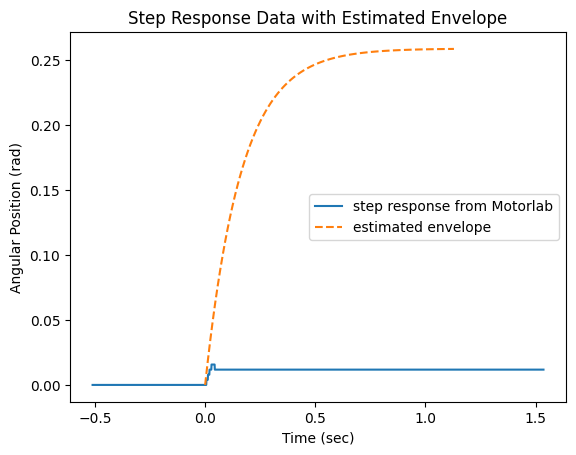

In [36]:
# motor inertia (kg-m^2 or N-m-s^2/rad)
J = 1.1e-5 + 0.19e-5

# spring constant (N-m/rad)
ks = k_estimate
 
# DC gain of transfer function
Kdc = kt/ks

# natural freqency (rad/s)
wn = sqrt(ks / J)

# estimated damping ratio
zeta_estimate = 0.05
 
# Generate a step response from a first order system with a pole
# equal to the real part of the 2nd order poles


# real part of poles 
real_part = zeta_estimate * wn
envelope_TF = tf(Kdc * real_part, [1, real_part])
[envelope_y, envelope_time] = step(envelope_TF)

# Extract data from the experimentally generated step response
# stepdata = loadmat("lab4Data")['stepdata']
stepdata = pd.read_csv("stepdata.csv", header=None)

# extract time column of the data matrix
# dataTime = [x[0] for x in stepdata]
dataTime = stepdata.iloc[:,0]

# extract third angle column of the data matrix
# dataAngle = [x[2] for x in stepdata]
dataAngle = stepdata.iloc[:,2]

# convert to rad
dataTh = kdr * dataAngle

plt.figure(2)
plt.plot(dataTime, dataTh, envelope_time, envelope_y, '--')
plt.ylabel('Angular Position (rad)')
plt.xlabel('Time (sec)')
plt.title('Step Response Data with Estimated Envelope')
plt.legend(['step response from Motorlab','estimated envelope'])
plt.show()

## Find coefficients and compare model to experimental data
Uncomment this section after completing the above section
* Find coefficients and compare model to experimental data
* Requires step response has been imported into stepdata
* Uncomment and complete the lines below to generate the step response comparison and to print coeficients

In [ ]:
# Print coefficients for different forms of the TF

# damping ratio
zeta_estimate

# natural frequency (rad/s)
wn

# friction coeffienct (N-m-s/rad)
b = 2 * zeta_estimate * wn * J

# damped oscillation frequency (rad/s)
wd = wn * sqrt(1 - zeta_estimate**2)

# period of oscillations (sec)
Tosc = 2 * pi / wd

# motor inertia (N-m-s^2/rad)
J

# spring constant (N-m/rad)
ks
 
# Print both forms of the TF
G = tf(kt / J, [1, 2 * zeta_estimate * wn, wn**2], display_format='zpk')
Gcheck = tf(kt, [J, b, ks], display_format='zpk')
print("G = {}".format(G))
print("G = {}".format(Gcheck))

# size of step input
I = 1

# get the theoretical step response
[theoryTh, theoryTime] = step(I * G)
 
# DO THE PLOT COMPARING THE ACTUAL STEP RESPONSE TO THE MODEL
plt.figure(3)
plt.plot(dataTime, dataTh, theoryTime, theoryTh, '--')
plt.ylabel('Angular Position (rad)')
plt.xlabel('Time (sec)')
plt.title('Step Response Data with Estimated Envelope')
plt.legend(['step response from Motorlab','Theoretical Step Response'])
plt.show()